In [1]:
import os
import pickle
import numpy as np

In [ ]:
path = './data/dense/'
set_my = 'train'
# load visual data
# Training set
v_train_data = open(os.path.join(path, set_my+'Set_visual.p'), 'rb')
# load
visual_train = pickle.load(v_train_data)
# convert to vector
visual_train = np.asarray(visual_train)
# Validation set
v_val_data = open(os.path.join(path, 'valSet_visual.p'), 'rb')
visual_val = pickle.load(v_val_data)
visual_val = np.asarray(visual_val)
# Test Set
v_test_data = open(os.path.join(path, 'testSet_visual.p'), 'rb')
visual_test = pickle.load(v_test_data)
visual_test = np.asarray(visual_test)

# Reading audio data
a_train_data = open(os.path.join(path, set_my+'Set_audio.p'), 'rb')
audio_train = pickle.load(a_train_data)
audio_train = np.asarray(audio_train)

a_val_data = open(os.path.join(path, 'valSet_audio.p'), 'rb')
audio_val = pickle.load(a_val_data)
audio_val = np.asarray(audio_val)

a_test_data = open(os.path.join(path, 'testSet_audio.p'), 'rb')
audio_test = pickle.load(a_test_data)
audio_test = np.asarray(audio_test)

# load Tags
train_target = open(os.path.join(path, set_my+'Set_target.p'), 'rb')
target_train = pickle.load(train_target)
target_train = np.asarray(target_train)

val_target = open(os.path.join(path, 'valSet_target.p'), 'rb')
target_val = pickle.load(val_target)
target_val = np.asarray(target_val)

test_target = open(os.path.join(path, 'testSet_target.p'), 'rb')
target_test = pickle.load(test_target)
target_test = np.asarray(target_test)

print('visual_train:', visual_train.shape)
print('visual_val:', visual_val.shape)
print('visual_test:', visual_test.shape)
print('audio_train:', audio_train.shape)
print('audio_val:', audio_val.shape)
print('audio_test:', audio_test.shape)
print('target_train:', target_train.shape)
print('target_val:', target_val.shape)
print('target_test:', target_test.shape)
print('data load done')
print('-----------------')

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras import callbacks

In [4]:
visual_input_shape = (10, 1920)  # Visual Input 
audio_input_shape = (10, 12, 8, 512)  # Audio input
num_classes = 28  # Number of categories

In [4]:
def create_multimodal_model(visual_input_shape, audio_input_shape, num_classes):
    # Visual sub-model
    visual_input = Input(shape=visual_input_shape)
    visual_model = layers.TimeDistributed(layers.Dense(256, activation='relu'))(visual_input) # Fully connected layer
    visual_model = layers.LSTM(64)(visual_model)

    # Audio sub-model
    audio_input = Input(shape=audio_input_shape)
    audio_model = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))(audio_input)
    audio_model = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(audio_model)
    audio_model = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))(audio_model)
    audio_model = layers.TimeDistributed(layers.Flatten())(audio_model) # Flatten into a 1-dimensional vector
    audio_model = layers.LSTM(64)(audio_model)

    # Fusion of visual and audio features
    combined = layers.concatenate([visual_model, audio_model])

    # Adding feature attention mechanism
    attention_probs = layers.Dense(combined.shape[1], activation='softmax', name='attention_vec')(combined)
    attention_mul = layers.multiply([combined, attention_probs])

    # Fully connected classifier
    combined_with_attention = layers.Dense(128, activation='relu')(attention_mul)
    output = layers.Dense(num_classes, activation='softmax')(combined_with_attention) # 多分类的激活函数

    # Defining Model
    model = models.Model(inputs=[visual_input, audio_input], outputs=output)
    return model

visual_input_shape = (10, 1920)  # Visual  Input
audio_input_shape = (10, 12, 8, 512)  # Audio input
num_classes = 28  # Number of categories

# Creating and compiling a multimodal model
multimodal_model = create_multimodal_model(visual_input_shape, audio_input_shape, num_classes)
multimodal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# multimodal_model.fit([visual_train, audio_train], target_train, validation_data=([visual_val, audio_val], target_val), epochs=300, batch_size=64)
# multimodal_model.evaluate([visual_test, audio_test], target_test)


In [ ]:
# callback function
#Early stopping implementation
#Avoid overfitting by monitoring the performance on the validation set during training and implementing early stopping. 
#Early stopping is a strategy that stops training when the performance on the validation set does not improve, to prevent the model from overfitting on the training set.
checkpoint_cb = callbacks.ModelCheckpoint(
    "best_model.h5", save_best_only=True)  # Save the best model
early_stopping_cb = callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)  

# Training and evaluation
history = multimodal_model.fit(
    [visual_train, audio_train], target_train,
    validation_data=([visual_val, audio_val], target_val),
    epochs=300,  # Try more rounds
    batch_size=64,  
    callbacks=[checkpoint_cb, early_stopping_cb]  # callback
)

Epoch 1/300
53/53 [==============================] - 22s 207ms/step - loss: 3.2610 - accuracy: 0.1036 - val_loss: 3.0963 - val_accuracy: 0.1144
Epoch 2/300
53/53 [==============================] - 2s 43ms/step - loss: 2.9321 - accuracy: 0.1171 - val_loss: 2.7453 - val_accuracy: 0.1468
Epoch 3/300
53/53 [==============================] - 2s 43ms/step - loss: 2.6312 - accuracy: 0.1402 - val_loss: 2.5181 - val_accuracy: 0.2114
Epoch 4/300
53/53 [==============================] - 2s 43ms/step - loss: 2.5007 - accuracy: 0.1665 - val_loss: 2.3847 - val_accuracy: 0.2040
Epoch 5/300
53/53 [==============================] - 2s 42ms/step - loss: 2.3359 - accuracy: 0.1899 - val_loss: 2.2617 - val_accuracy: 0.2189
Epoch 6/300
53/53 [==============================] - 2s 43ms/step - loss: 2.2128 - accuracy: 0.2114 - val_loss: 2.1542 - val_accuracy: 0.2562
Epoch 7/300
53/53 [==============================] - 2s 42ms/step - loss: 2.1564 - accuracy: 0.2183 - val_loss: 2.0966 - val_accuracy: 0.2736
Epoc

13/13 [==============================] - 0s 15ms/step - loss: 1.5253 - accuracy: 0.5174
Test Loss: 1.5253288745880127, Test Accuracy: 0.5174129605293274


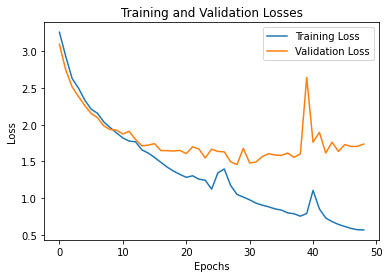

In [6]:
# test model
test_loss, test_acc = multimodal_model.evaluate([visual_test, audio_test], target_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Self-Attention

In [5]:
class SelfAttention(layers.Layer):
    def __init__(self, embed_size, **kwargs):
        super(SelfAttention, self).__init__(**kwargs)
        self.embed_size = embed_size
        self.WQ = layers.Dense(embed_size, use_bias=False)
        self.WK = layers.Dense(embed_size, use_bias=False)
        self.WV = layers.Dense(embed_size, use_bias=False)
    
    def call(self, x):
        Q = self.WQ(x)
        K = self.WK(x)
        V = self.WV(x)
        
        attention_scores = tf.matmul(Q, K, transpose_b=True)
        attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.embed_size, tf.float32))
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        
        output = tf.matmul(attention_weights, V)
        return output

    def get_config(self):
        config = super(SelfAttention, self).get_config()
        config.update({"embed_size": self.embed_size})
        return config


In [11]:
from tensorflow.keras import layers, models, Input

# class SelfAttention(layers.Layer):
#     def __init__(self, embed_size, **kwargs):
#         super(SelfAttention, self).__init__(**kwargs)
#         self.embed_size = embed_size
#         self.WQ = layers.Dense(embed_size, use_bias=False)
#         self.WK = layers.Dense(embed_size, use_bias=False)
#         self.WV = layers.Dense(embed_size, use_bias=False)
    
#     def call(self, x):
#         Q = self.WQ(x)
#         K = self.WK(x)
#         V = self.WV(x)
        
#         # Calculating attention scores
#         attention_scores = tf.matmul(Q, K, transpose_b=True)
#         attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.embed_size, tf.float32))
#         attention_weights = tf.nn.softmax(attention_scores, axis=-1)
        
#         # Applying attention weights
#         output = tf.matmul(attention_weights, V)
#         return output

def create_multimodal_model(visual_input_shape, audio_input_shape, num_classes):
    # Visual sub-model
    visual_input = Input(shape=visual_input_shape)
    visual_model = layers.TimeDistributed(layers.Dense(256, activation='relu'))(visual_input)
    visual_model = layers.LSTM(64)(visual_model)

    # Audio sub-model
    audio_input = Input(shape=audio_input_shape)
    audio_model = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))(audio_input)
    audio_model = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(audio_model)
    audio_model = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))(audio_model)
    audio_model = layers.TimeDistributed(layers.Flatten())(audio_model)
    audio_model = layers.LSTM(64)(audio_model)

    # Fusion of visual and audio features
    combined = layers.concatenate([visual_model, audio_model])

    # Adding self-attention mechanism
    self_attention = SelfAttention(embed_size=128)(combined)
    
    # Fully connected classifier
    combined_with_attention = layers.Dense(128, activation='relu')(self_attention)
    output = layers.Dense(num_classes, activation='softmax')(combined_with_attention)

    # define model
    model = models.Model(inputs=[visual_input, audio_input], outputs=output)
    return model


multimodal_model = create_multimodal_model(visual_input_shape, audio_input_shape, num_classes)
multimodal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
multimodal_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 10, 12, 8,   0           []                               
                                512)]                                                             
                                                                                                  
 time_distributed_16 (TimeDistr  (None, 10, 12, 8, 3  147488     ['input_8[0][0]']                
 ibuted)                        2)                                                                
                                                                                                  
 time_distributed_17 (TimeDistr  (None, 10, 6, 4, 32  0          ['time_distributed_16[0][0]']    
 ibuted)                        )                                                           

In [14]:
# callback function
checkpoint_cb = callbacks.ModelCheckpoint(
    "best_model_selfatt.h5", save_best_only=True)  # save model
early_stopping_cb = callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)  


history = multimodal_model.fit(
    [visual_train, audio_train], target_train,
    validation_data=([visual_val, audio_val], target_val),
    epochs=300,  
    batch_size=64,  
    callbacks=[checkpoint_cb, early_stopping_cb]  
)

Epoch 1/300
53/53 [==============================] - 10s 85ms/step - loss: 3.3153 - accuracy: 0.0440 - val_loss: 3.2904 - val_accuracy: 0.0423
Epoch 2/300
53/53 [==============================] - 3s 51ms/step - loss: 3.2989 - accuracy: 0.0446 - val_loss: 3.2922 - val_accuracy: 0.0448
Epoch 3/300
53/53 [==============================] - 2s 44ms/step - loss: 3.2980 - accuracy: 0.0425 - val_loss: 3.2906 - val_accuracy: 0.0448
Epoch 4/300
53/53 [==============================] - 2s 45ms/step - loss: 3.2937 - accuracy: 0.0440 - val_loss: 3.2853 - val_accuracy: 0.0448
Epoch 5/300
53/53 [==============================] - 2s 45ms/step - loss: 3.2933 - accuracy: 0.0440 - val_loss: 3.2860 - val_accuracy: 0.0448
Epoch 6/300
53/53 [==============================] - 2s 46ms/step - loss: 3.2925 - accuracy: 0.0413 - val_loss: 3.2844 - val_accuracy: 0.0448
Epoch 7/300
53/53 [==============================] - 2s 44ms/step - loss: 3.2916 - accuracy: 0.0428 - val_loss: 3.2850 - val_accuracy: 0.0448
Epoch

13/13 [==============================] - 0s 19ms/step - loss: 1.2692 - accuracy: 0.7637
Test Loss: 1.2692184448242188, Test Accuracy: 0.7636815905570984


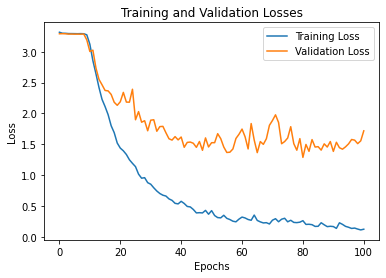

In [15]:
# evaluation
test_loss, test_acc = multimodal_model.evaluate([visual_test, audio_test], target_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Multi-head Attention

In [21]:
from tensorflow.keras import layers, models, Input
from tensorflow.keras.layers import MultiHeadAttention

def create_multimodal_model(visual_input_shape, audio_input_shape, num_classes):

    visual_input = Input(shape=visual_input_shape)
    visual_model = layers.TimeDistributed(layers.Dense(256, activation='relu'))(visual_input)
    visual_model = layers.LSTM(64, return_sequences=True)(visual_model) 

    audio_input = Input(shape=audio_input_shape)
    audio_model = layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))(audio_input)
    audio_model = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(audio_model)
    audio_model = layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))(audio_model)
    audio_model = layers.TimeDistributed(layers.Flatten())(audio_model)
    audio_model = layers.LSTM(64, return_sequences=True)(audio_model)  


    combined = layers.concatenate([visual_model, audio_model], axis=-1)

    # combined = layers.Flatten()(combined)
    # print(combined.shape)
    # Dense
    dense = layers.Dense(128, activation='relu')(combined)
    # Add Multi-head Attention
    multi_head_attention = MultiHeadAttention(num_heads=2, key_dim=128)(dense, dense)


    combined_with_attention = layers.Dense(64, activation='relu')(multi_head_attention)
    combined_with_attention = layers.GlobalAveragePooling1D()(combined_with_attention)  
    output = layers.Dense(num_classes, activation='softmax')(combined_with_attention)


    model = models.Model(inputs=[visual_input, audio_input], outputs=output)
    return model


In [22]:
multimodal_model = create_multimodal_model(visual_input_shape, audio_input_shape, num_classes)
multimodal_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

multimodal_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 10, 12, 8,   0           []                               
                                512)]                                                             
                                                                                                  
 time_distributed_36 (TimeDistr  (None, 10, 12, 8, 3  147488     ['input_16[0][0]']               
 ibuted)                        2)                                                                
                                                                                                  
 time_distributed_37 (TimeDistr  (None, 10, 6, 4, 32  0          ['time_distributed_36[0][0]']    
 ibuted)                        )                                                           

In [23]:
history = multimodal_model.fit([visual_train, audio_train], target_train,
                                validation_data=([visual_val, audio_val], target_val),
                                epochs=50, batch_size=64)


Epoch 1/50
53/53 [==============================] - 6s 60ms/step - loss: 2.3887 - accuracy: 0.2830 - val_loss: 1.4325 - val_accuracy: 0.4652
Epoch 2/50
53/53 [==============================] - 2s 41ms/step - loss: 1.1657 - accuracy: 0.5885 - val_loss: 1.0484 - val_accuracy: 0.6194
Epoch 3/50
53/53 [==============================] - 2s 40ms/step - loss: 0.8420 - accuracy: 0.6993 - val_loss: 0.8150 - val_accuracy: 0.7090
Epoch 4/50
53/53 [==============================] - 2s 41ms/step - loss: 0.5825 - accuracy: 0.7904 - val_loss: 0.5969 - val_accuracy: 0.7985
Epoch 5/50
53/53 [==============================] - 2s 40ms/step - loss: 0.4388 - accuracy: 0.8473 - val_loss: 0.5637 - val_accuracy: 0.8109
Epoch 6/50
53/53 [==============================] - 2s 39ms/step - loss: 0.3641 - accuracy: 0.8781 - val_loss: 0.6523 - val_accuracy: 0.7861
Epoch 7/50
53/53 [==============================] - 2s 39ms/step - loss: 0.2762 - accuracy: 0.9039 - val_loss: 0.6187 - val_accuracy: 0.8259
Epoch 8/50
53

In [19]:

# checkpoint_cb = callbacks.ModelCheckpoint(
#     "best_model_selfatt2.h5", save_best_only=True)  
# early_stopping_cb = callbacks.EarlyStopping(
#     patience=20, restore_best_weights=True)  


# history = multimodal_model.fit(
#     [visual_train, audio_train], target_train,
#     validation_data=([visual_val, audio_val], target_val),
#     epochs=300, 
#     batch_size=64,  
#     callbacks=[checkpoint_cb, early_stopping_cb]  
# )

Epoch 1/300
53/53 [==============================] - 8s 97ms/step - loss: 2.4080 - accuracy: 0.2986 - val_loss: 1.4794 - val_accuracy: 0.5075
Epoch 2/300
53/53 [==============================] - 5s 105ms/step - loss: 1.2263 - accuracy: 0.5612 - val_loss: 1.0416 - val_accuracy: 0.6468
Epoch 3/300
53/53 [==============================] - 3s 66ms/step - loss: 0.8818 - accuracy: 0.6810 - val_loss: 0.8552 - val_accuracy: 0.7015
Epoch 4/300
53/53 [==============================] - 5s 92ms/step - loss: 0.6067 - accuracy: 0.7850 - val_loss: 0.7543 - val_accuracy: 0.7239
Epoch 5/300
53/53 [==============================] - 3s 63ms/step - loss: 0.4830 - accuracy: 0.8314 - val_loss: 0.6863 - val_accuracy: 0.7736
Epoch 6/300
53/53 [==============================] - 3s 59ms/step - loss: 0.3392 - accuracy: 0.8841 - val_loss: 0.5374 - val_accuracy: 0.7935
Epoch 7/300
53/53 [==============================] - 4s 70ms/step - loss: 0.2813 - accuracy: 0.9015 - val_loss: 0.5306 - val_accuracy: 0.8085
Epoch

13/13 [==============================] - 0s 15ms/step - loss: 1.0555 - accuracy: 0.8010
Test Loss: 1.0554888248443604, Test Accuracy: 0.8009950518608093


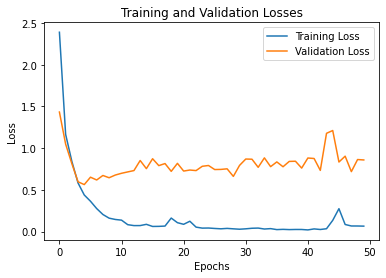

In [24]:
# Evaluate model
test_loss, test_acc = multimodal_model.evaluate([visual_test, audio_test], target_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

# Plot the training and validation loss curves
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
